# Outline

CNN-based architectures have become integral to virtually all existing computer-vision solutions. Given their central role, it is important to better understand some of their limitations. From a theoretical perspective, CNN-based architectures can be viewed as ordinary DNN's albeit with strong weight-sharing structure.

In the explorations presented here, we focus on the MNIST due mostly to the small size of the input images. For a list of results on the MNIST task, see [this page](http://yann.lecun.com/exdb/mnist/).

Below, we will explore the following aspects:
 - How much does input normalization matter?
 - Are CNNs less suscpetibile to overfitting due to having smaller model capacities compared to fully-connected DNNs?
 - Last and perhaps most important of all, can CNNs be effective when the input image is completely scrambled, albeit in a reversable way?

In [1]:
import os
import sys
import json

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

<br><br><br>

# Utilities

In [2]:
def dataset_splitter(x_set, y_set, fraction=0.2):
    """Splits the data set into train and validation sets.
    
    Args:
        x_set (np.ndarray):
        y_set (np.ndarray):
        fraction (float): The fraction of the data to be 
    
    Returns:
        (x_train, y_trin), (x_validation, y_validation)
    """
    dataset_size = y_set.shape[0]
    split_mask = np.where(
        np.random.uniform(size=dataset_size) > fraction, True, False)
    np.random.shuffle(split_mask)
    
    x_train = x_set[split_mask]
    y_train = y_set[split_mask]
    
    x_validation = x_set[np.logical_not(split_mask)]
    y_validation = y_set[np.logical_not(split_mask)]
    
    return (
        (x_train, y_train), (x_validation, y_validation))


class Scrambler():
    def __init__(self, target_shape):
        self._target_shape = target_shape
        self._initialize_scramble()
        
    def _initialize_scramble(self):
        self._scrambling_array = np.arange(np.prod(self._target_shape))
        np.random.shuffle(self._scrambling_array)
        self._scrambling_array_inverse = np.argsort(self._scrambling_array)
        
    def scramble(self, x):
        x_shape = x.shape
        if np.prod(x[0].shape) == np.prod(self._target_shape):
            return x.reshape(
                (x_shape[0], self._scrambling_array.shape[0])
            )[:, self._scrambling_array].reshape(x_shape)
        elif np.prod(x.shape) == np.prod(self._target_shape):
            return x.flatten()[self._scrambling_array].reshape(x_shape)
        else:
            raise ValueError(f"The input shape, {x.shape}, is not valid!")
    
    def unscramble(self, x):
        x_shape = x.shape
        if np.prod(x[0].shape) == np.prod(self._target_shape):
            return x.reshape(
                (x_shape[0], self._scrambling_array.shape[0])
            )[:, self._scrambling_array_inverse].reshape(x_shape)
        elif np.prod(x.shape) == np.prod(self._target_shape):
            return x.flatten()[self._scrambling_array_inverse].reshape(x_shape)
        else:
            raise ValueError(f"The input shape, {x.shape}, is not valid!")
        
    def set_scrambling_array(self, scrambing_array, copy=True):
        if scrambing_array.shape != self._scrambling_array.shape:
            raise ValueError(f"The array does not have the right shape:\n\
            {scrambing_array.shape} vs. {self._scrambling_array.shape}!")
        if copy:
            self._scrambling_array = np.copy(scrambing_array)
            self._scrambling_array_inverse = np.argsort(self._scrambling_array)
        else:
            self._scrambling_array = scrambing_array
            self._scrambling_array_inverse = np.argsort(self._scrambling_array)
        
    def get_scrambling_array(self, copy=True):
        if copy:
            return np.copy(self._scrambling_array)
        else:
            return self._scrambling_array

        
class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, 
        x_set, 
        y_set, 
        batch_size, 
        preprocessor_func=None
    ):
        """Initializes the instance of Sequence.
        
        Args:
            x_set (np.ndarray): Inputs/Features
            y_set (np.ndarray): Labels
            batch_size (int): Size of batches to be yielded.
            preprocessor_func: A callable that if provided with be applied on
                the feature batches.
        """
        self._x, self._y = x_set, y_set
        self._batch_size = int(batch_size)
        self._preprocessor_func = preprocessor_func
            
    def set_batch_size(self, batch_size):
        self._batch_size = int(batch_size)
        
    def set_preprocessor(self, preprocessor_func):
        self._preprocessor_func = preprocessor_func

    def __len__(self):
        return (len(self._y) // self._batch_size)

    def __getitem__(self, idx):
        batch_x = self._x[idx * self._batch_size: (idx + 1) * self._batch_size]
        if self._preprocessor_func is not None:
            batch_x = self._preprocessor_func(batch_x)
        batch_y = self._y[idx * self._batch_size: (idx + 1) * self._batch_size]
        return (batch_x, batch_y)
    
    def get_config(self):
        """Not used for serialization! 
        """
        return {
            "x shape": str(self._x.shape),
            "y shape": str(self._y.shape),
            "batch size": self._batch_size,
            "input preprocessing": self._preprocessor_func is not None}

In [3]:
def evaluate_model(model, x, y=None):
    """Evaluates model on the provided dataset.
    Accepts both x, y np.ndarrays and generators.
    
    Args:
        model (tf.keras.Model)
        x (np.ndarray or generator)
        y (np.ndarray or None)
    """
    if y is None:
        eval_results = model.evaluate(
            x, return_dict=True, verbose=0)
    else:
        eval_results = model.evaluate(
            x, y, return_dict=True, verbose=0)

    for name, val in eval_results.items():
        print(f"\t{name:16}{round(float(val), 5)}")

        
def training_history_plots(history_callback, **kwargs):
    """Plots the training history from an instance of the history callback.
    
    Args:
        history_callback (tf.keras.callbacks.History): Model training history.
    """
    train_losses = history_callback.history["loss"]
    val_losses = history_callback.history.get("val_loss", None)
    train_accuracy = history_callback.history.get("accuracy", None)
    val_accuracy = history_callback.history.get("val_accuracy", None)
    num_epochs = len(train_losses)
    epochs = np.linspace(start=1, stop=num_epochs, num=num_epochs, endpoint=True)

    fig = plt.figure(figsize=kwargs.get("figsize", (18., 13.)))
    plt.suptitle("Training History", fontsize=18)
    #
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_ylabel("Crossentropy", fontsize=14., color="gray")
    ax1.plot(epochs, train_losses, marker="", lw=2.0, color="orange", label="Train")
    if val_losses is not None :
        ax1.plot(epochs, val_losses, marker="", lw=2.0, color="steelblue", label="Validation")
    ax1.grid()
    ax1.set_axisbelow(True)
    ax1.legend(loc="upper right", fontsize=12)
    #
    ax2 = plt.subplot(2, 1, 2)
    ax2.set_xlabel("Epoch", fontsize=14., color="gray")
    ax2.set_ylabel("Accuracy", fontsize=14., color="gray")
    if train_accuracy is not None :
        ax2.plot(epochs, train_accuracy, marker="", lw=2.0, color="orange", label="Train")
    if val_accuracy is not None :
        ax2.plot(epochs, val_accuracy, marker="", lw=2.0, color="steelblue", label="Validation")
    ax2.grid()
    ax2.set_axisbelow(True)
    ax2.legend(loc="upper right", fontsize=12)
    #
    plt.show()

In [4]:
def lr_schedule(epoch, lr, num_initial_epochs=5, decay_rate=0.75, min_lr=0.0001):
    """Learning rate schedule.
    """
    if (epoch < num_initial_epochs): 
        return lr
    elif lr > min_lr: 
        return decay_rate * lr
    else:
        return lr

<br><br><br>

# Load MNIST Dataset

In [5]:
(x_train_set, y_train_set), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"\t Train Set: {x_train_set.shape}, {y_train_set.shape}")
print(f"\t Test Set:  {x_test.shape}, {y_test.shape}")

	 Train Set: (60000, 28, 28), (60000,)
	 Test Set:  (10000, 28, 28), (10000,)


## Split Train Set into Train and Validation Sets

In [6]:
(x_train, y_train), (x_validation, y_validation) = dataset_splitter(
    x_train_set, y_train_set, 0.2)

train_set_size_frac = round(y_train.shape[0] / y_train_set.shape[0], 3)
valid_set_size_frac = round(y_validation.shape[0] / y_train_set.shape[0], 3)
print(f"\t Training Set:   {x_train.shape}, {y_train.shape} is {train_set_size_frac}\
 fracton of the original set.")
print(f"\t Validation Set: {x_validation.shape}, {y_validation.shape} is {valid_set_size_frac}\
 fracton of the original set.")

	 Training Set:   (47946, 28, 28), (47946,) is 0.799 fracton of the original set.
	 Validation Set: (12054, 28, 28), (12054,) is 0.201 fracton of the original set.


## Instantiate Sequence Generators

In [7]:
# test_sequence_generator = SequenceGenerator(
#     x_test, y_test, batch_size=32)
# print("Test Generator Config:\t", json.dumps(
#     test_sequence_generator.get_config(), indent=4), end="\n\n")

train_sequence_generator = SequenceGenerator(
    x_train, y_train, batch_size=32)
# print("Train Generator Config:\t", json.dumps(
#     train_sequence_generator.get_config(), indent=4), end="\n\n")

validation_sequence_generator = SequenceGenerator(
    x_validation, y_validation, batch_size=32)
# print("Validation Generator Config:\t", json.dumps(
#     validation_sequence_generator.get_config(), indent=4))

Train Generator Config:	 {
    "x shape": "(47946, 28, 28)",
    "y shape": "(47946,)",
    "batch size": 32,
    "input preprocessing": false
}

Validation Generator Config:	 {
    "x shape": "(12054, 28, 28)",
    "y shape": "(12054,)",
    "batch size": 32,
    "input preprocessing": false
}


<br><br><br>

# Explorations

## LeNet-5:

In [8]:
def lenet5(name="LeNet-5"):
    inputs = tf.keras.Input(shape=(28, 28, 1), name="input")
    x = tf.keras.layers.Conv2D(
        filters=6, 
        kernel_size=(5, 5), 
        strides=(1, 1), 
        padding="same",
        data_format="channels_last", 
        dilation_rate=(1, 1), 
        groups=1,
        activation=tf.keras.activations.tanh,
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', 
        kernel_regularizer=None, bias_regularizer=None, 
        activity_regularizer=None, 
        kernel_constraint=None, bias_constraint=None,
        name="conv_1")(inputs)
    x = tf.keras.layers.AveragePooling2D(
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding='valid', 
        data_format=None,
        name="avg_pooling_1")(x)
    x = tf.keras.layers.Conv2D(
        filters=16, 
        kernel_size=(5, 5), 
        strides=(1, 1), 
        padding="valid",
        data_format="channels_last", 
        dilation_rate=(1, 1), 
        groups=1,
        activation=tf.keras.activations.tanh,
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', 
        kernel_regularizer=None, bias_regularizer=None, 
        activity_regularizer=None, 
        kernel_constraint=None, bias_constraint=None,
        name="conv_2")(x)
    x = tf.keras.layers.AveragePooling2D(
        pool_size=(2, 2), 
        strides=(2, 2), 
        padding='valid', 
        data_format=None,
        name="avg_pooling_2")(x)
    x = tf.keras.layers.Conv2D(
        filters=120, 
        kernel_size=(5, 5), 
        strides=(1, 1), 
        padding="valid",
        data_format="channels_last", 
        dilation_rate=(1, 1), 
        groups=1,
        activation=tf.keras.activations.tanh,
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', 
        kernel_regularizer=None, bias_regularizer=None, 
        activity_regularizer=None, 
        kernel_constraint=None, bias_constraint=None,
        name="conv_3")(x)
    x = tf.keras.layers.Flatten(name="flatten")(x)
    x = tf.keras.layers.Dense(
        units=84, 
        activation=tf.keras.activations.tanh, 
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', kernel_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        bias_constraint=None,
        name="dense_1")(x)
    outputs = tf.keras.layers.Dense(
        units=10, 
        activation=tf.keras.activations.softmax, 
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', kernel_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        bias_constraint=None,
        name="output")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    
    
lenet5_model = lenet5() 
lenet5_model.summary(print_fn=(lambda *args: print("\t", *args)))

	 Model: "LeNet-5"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input (InputLayer)           [(None, 28, 28, 1)]       0         
	 _________________________________________________________________
	 conv_1 (Conv2D)              (None, 28, 28, 6)         156       
	 _________________________________________________________________
	 avg_pooling_1 (AveragePoolin (None, 14, 14, 6)         0         
	 _________________________________________________________________
	 conv_2 (Conv2D)              (None, 10, 10, 16)        2416      
	 _________________________________________________________________
	 avg_pooling_2 (AveragePoolin (None, 5, 5, 16)          0         
	 _________________________________________________________________
	 conv_3 (Conv2D)              (None, 1, 1, 120)         48120     
	 _________________________________________________________________
	 flatten (Flatten)          

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0)
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
#     epsilon=1e-07, amsgrad=False, name="Adam")

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

lenet5_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
1498/1498 - 19s - loss: 0.1779 - accuracy: 0.9473 - val_loss: 0.1124 - val_accuracy: 0.9643

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
1498/1498 - 19s - loss: 0.0843 - accuracy: 0.9737 - val_loss: 0.0865 - val_accuracy: 0.9734

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
1498/1498 - 19s - loss: 0.0635 - accuracy: 0.9800 - val_loss: 0.0645 - val_accuracy: 0.9799

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
1498/1498 - 19s - loss: 0.0471 - accuracy: 0.9851 - val_loss: 0.0518 - val_accuracy: 0.9850

Epoch 00005: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 5/100
1498/1498 - 19s - loss: 0.0393 - accuracy: 0.9870 - val_loss: 0.0492 - val_accuracy: 0.9847

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0

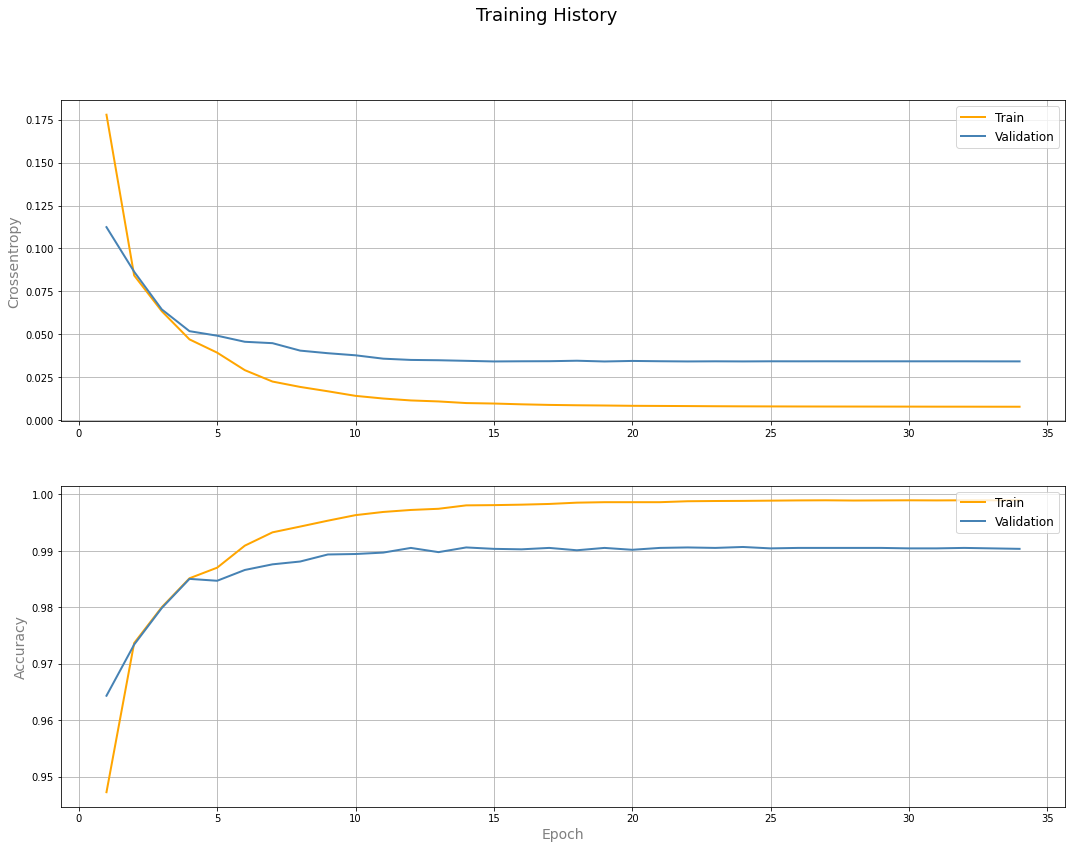

In [10]:
num_epochs = 100

# Learning rate schedule
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch, lr: lr_schedule(
        epoch, lr, num_initial_epochs=5, decay_rate=0.8, min_lr=0.001), 
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001, 
    patience=20, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

train_sequence_generator.set_preprocessor(lambda x: x[..., np.newaxis])
train_sequence_generator.set_batch_size(32)

validation_sequence_generator.set_preprocessor(lambda x: x[..., np.newaxis])
validation_sequence_generator.set_batch_size(32)

# Fit model
fit_history = lenet5_model.fit(
    train_sequence_generator,
    epochs=num_epochs,
    verbose=0,
    validation_data=validation_sequence_generator,
    shuffle=True,
    class_weight=None,
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

training_history_plots(fit_history)

In [11]:
evaluate_model(lenet5_model, x_test[..., np.newaxis], y_test)

	loss            0.0296
	accuracy        0.9898


# A Fully-Connected Model:

In [12]:
def construct_dense_model(name="FCM"):
    inputs = tf.keras.Input(shape=(28, 28), name="input")
    x = tf.keras.layers.Flatten(name="flatten")(inputs)
    x = tf.keras.layers.Dense(
        units=512, 
        activation=tf.keras.activations.tanh, 
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', kernel_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        bias_constraint=None,
        name="dense_1")(x)
    # x = tf.keras.layers.Dropout(rate=0.1, name="dropout_1")(x)
    x = tf.keras.layers.Dense(
        units=128, 
        activation=tf.keras.activations.tanh, 
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', kernel_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        bias_constraint=None,
        name="dense_3")(x)
    outputs = tf.keras.layers.Dense(
        units=10, 
        activation=tf.keras.activations.softmax, 
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros', kernel_regularizer=None,
        bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        bias_constraint=None,
        name="output")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

dense_model = construct_dense_model()
dense_model.summary(print_fn=(lambda *args: print("\t", *args)))

	 Model: "FCM"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input (InputLayer)           [(None, 28, 28)]          0         
	 _________________________________________________________________
	 flatten (Flatten)            (None, 784)               0         
	 _________________________________________________________________
	 dense_1 (Dense)              (None, 512)               401920    
	 _________________________________________________________________
	 dense_3 (Dense)              (None, 128)               65664     
	 _________________________________________________________________
	 output (Dense)               (None, 10)                1290      
	 Total params: 468,874
	 Trainable params: 468,874
	 Non-trainable params: 0
	 _________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0)
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
#     epsilon=1e-07, amsgrad=False, name="Adam")

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

dense_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
1498/1498 - 10s - loss: 0.3689 - accuracy: 0.8856 - val_loss: 0.1678 - val_accuracy: 0.9515

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
1498/1498 - 9s - loss: 0.1480 - accuracy: 0.9556 - val_loss: 0.1305 - val_accuracy: 0.9613

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
1498/1498 - 10s - loss: 0.1076 - accuracy: 0.9667 - val_loss: 0.1229 - val_accuracy: 0.9633

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
1498/1498 - 9s - loss: 0.0802 - accuracy: 0.9760 - val_loss: 0.1091 - val_accuracy: 0.9665

Epoch 00005: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 5/100
1498/1498 - 9s - loss: 0.0645 - accuracy: 0.9807 - val_loss: 0.0886 - val_accuracy: 0.9727

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0800

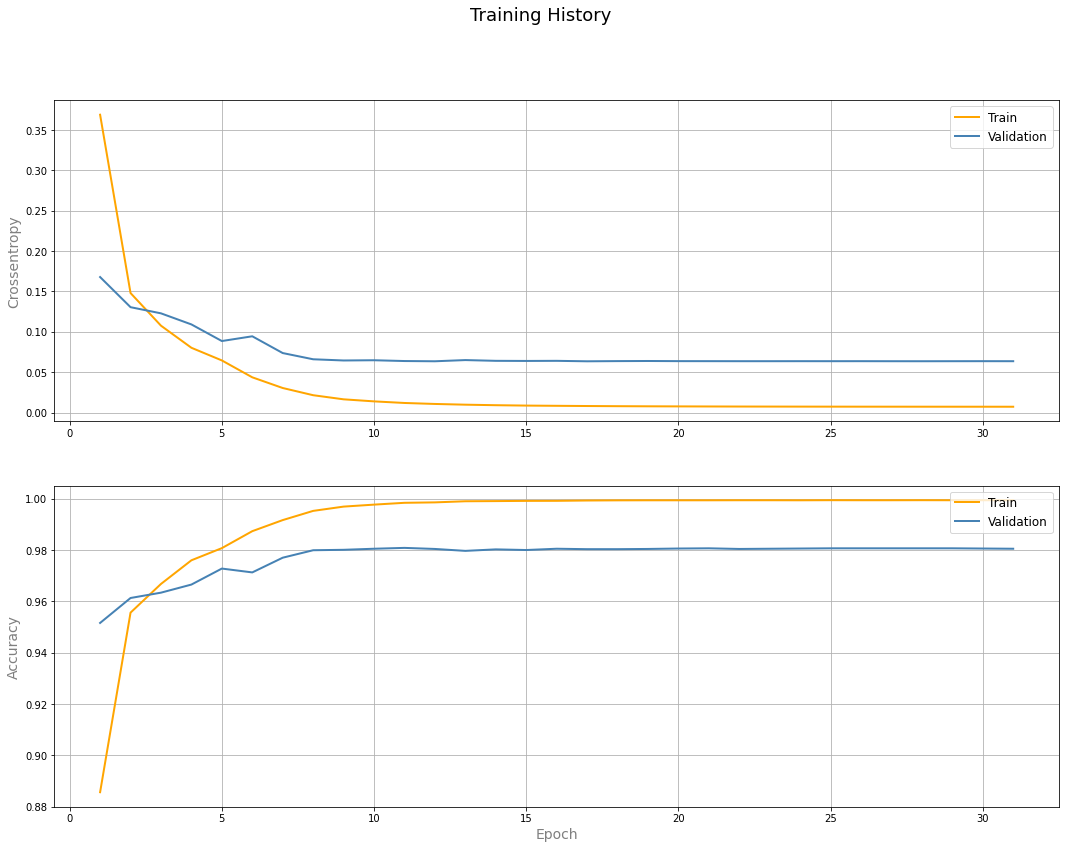

In [14]:
num_epochs = 100

lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch, lr: lr_schedule(
        epoch, lr, num_initial_epochs=5, decay_rate=0.8, min_lr=0.001),  
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.0005, 
    patience=20, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

train_sequence_generator.set_preprocessor(lambda x: x / 127.5 - 1.0)
train_sequence_generator.set_batch_size(32)

validation_sequence_generator.set_preprocessor(lambda x: x / 127.5 - 1.0)
validation_sequence_generator.set_batch_size(32)

# Fit model
fit_history = dense_model.fit(
    train_sequence_generator,
    epochs=num_epochs,
    verbose=0,
    validation_data=validation_sequence_generator,
    shuffle=True,
    class_weight=None,
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

training_history_plots(fit_history)

In [15]:
evaluate_model(dense_model, (x_test / 127.5 - 1.0), y_test)

	loss            0.06946
	accuracy        0.978


<br><br><br>

# Scrambled Input 

This time, we scramble the input images to see if the models retain their predictive power.

## Test the Scrambling Function

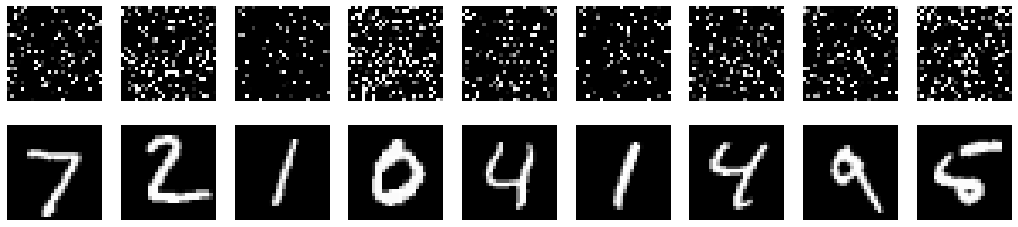

In [16]:
num_rows = 2
num_columns = 9

scrambler = Scrambler(x_test.shape[-2:])
scrambled_images = scrambler.scramble(x_test[0:num_columns, ...])
unscrambled_images = scrambler.unscramble(scrambled_images)

fig = plt.figure(figsize=(18., 4.))
for col in range(num_columns):
    ax = plt.subplot(num_rows, num_columns, col + 1)
    ax.imshow(scrambled_images[col,...], cmap="gray")
    ax.set_axis_off()
    #
    ax = plt.subplot(num_rows, num_columns, num_columns + col + 1)
    ax.imshow(unscrambled_images[col,...], cmap="gray")
    ax.set_axis_off()
plt.show()

## Train LeNet-5

In [17]:
# Create Model
lenet5_model_2 = lenet5()

# Compile:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
lenet5_model_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
1498/1498 - 18s - loss: 0.4951 - accuracy: 0.8493 - val_loss: 0.3484 - val_accuracy: 0.8930

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
1498/1498 - 18s - loss: 0.2815 - accuracy: 0.9146 - val_loss: 0.2471 - val_accuracy: 0.9240

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
1498/1498 - 17s - loss: 0.2074 - accuracy: 0.9363 - val_loss: 0.2106 - val_accuracy: 0.9355

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
1498/1498 - 18s - loss: 0.1688 - accuracy: 0.9470 - val_loss: 0.1808 - val_accuracy: 0.9435

Epoch 00005: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 5/100
1498/1498 - 19s - loss: 0.1490 - accuracy: 0.9528 - val_loss: 0.1777 - val_accuracy: 0.9449

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0

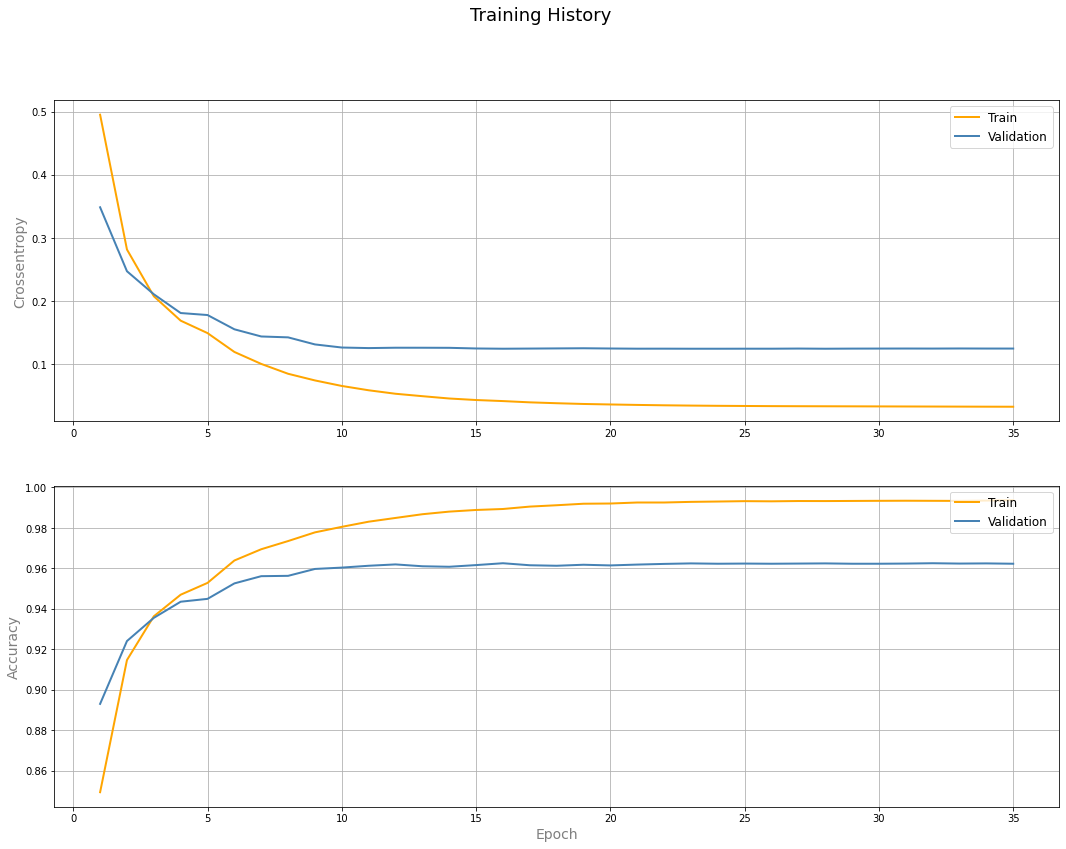

In [18]:
num_epochs = 100

# Learning rate schedule
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch, lr: lr_schedule(
        epoch, lr, num_initial_epochs=5, decay_rate=0.8, min_lr=0.001), 
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001, 
    patience=20, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

scrambler = Scrambler(x_test.shape[-2:])
train_sequence_generator.set_preprocessor(
    lambda x: scrambler.scramble(x[..., np.newaxis]))
train_sequence_generator.set_batch_size(32)
#
validation_sequence_generator.set_preprocessor(
    lambda x: scrambler.scramble(x[..., np.newaxis]))
validation_sequence_generator.set_batch_size(32)

# Fit model
fit_history = lenet5_model_2.fit(
    train_sequence_generator,
    epochs=num_epochs,
    verbose=0,
    validation_data=validation_sequence_generator,
    shuffle=True,
    class_weight=None,
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

training_history_plots(fit_history)

In [19]:
evaluate_model(
    lenet5_model_2, 
    scrambler.scramble(x_test[..., np.newaxis]), 
    y_test)

	loss            0.12035
	accuracy        0.9625


## Train the Dense Model:

In [20]:
# Construct Model
dense_model_2 = construct_dense_model()

# Compile
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
dense_model_2.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 1/100
1498/1498 - 7s - loss: 0.3710 - accuracy: 0.8876 - val_loss: 0.1894 - val_accuracy: 0.9425

Epoch 00002: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 2/100
1498/1498 - 7s - loss: 0.1523 - accuracy: 0.9539 - val_loss: 0.1334 - val_accuracy: 0.9581

Epoch 00003: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 3/100
1498/1498 - 7s - loss: 0.1078 - accuracy: 0.9676 - val_loss: 0.1108 - val_accuracy: 0.9645

Epoch 00004: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 4/100
1498/1498 - 7s - loss: 0.0819 - accuracy: 0.9754 - val_loss: 0.1027 - val_accuracy: 0.9704

Epoch 00005: LearningRateScheduler reducing learning rate to 0.10000000149011612.
Epoch 5/100
1498/1498 - 7s - loss: 0.0641 - accuracy: 0.9802 - val_loss: 0.0980 - val_accuracy: 0.9697

Epoch 00006: LearningRateScheduler reducing learning rate to 0.080000

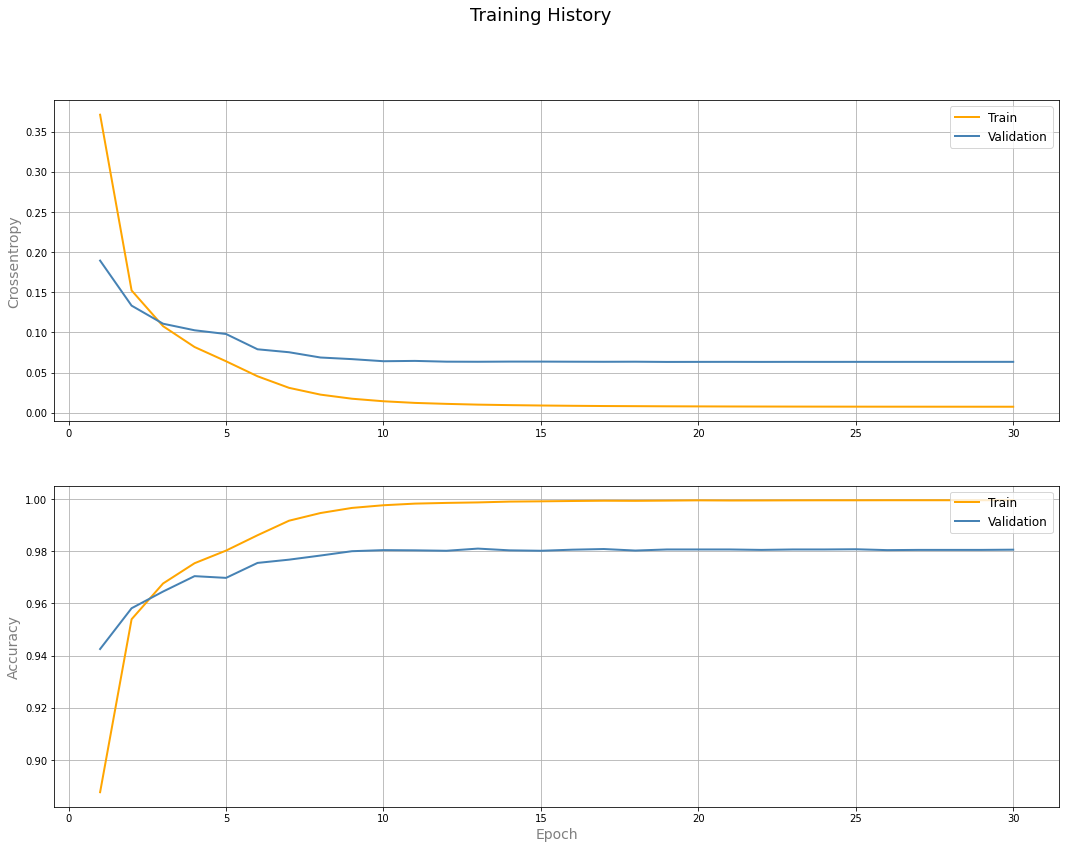

In [21]:
num_epochs = 100

# Learning rate schedule
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lambda epoch, lr: lr_schedule(
        epoch, lr, num_initial_epochs=5, decay_rate=0.8, min_lr=0.001), 
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001, 
    patience=20, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

scrambler = Scrambler(x_test.shape[-2:])
train_sequence_generator.set_preprocessor(
    lambda x: scrambler.scramble(x / 127.5 - 1.0))
train_sequence_generator.set_batch_size(32)
#
validation_sequence_generator.set_preprocessor(
    lambda x: scrambler.scramble(x / 127.5 - 1.0))
validation_sequence_generator.set_batch_size(32)

# Fit model
fit_history = dense_model_2.fit(
    train_sequence_generator,
    epochs=num_epochs,
    verbose=0,
    validation_data=validation_sequence_generator,
    shuffle=True,
    class_weight=None,
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

training_history_plots(fit_history)

In [22]:
evaluate_model(
    dense_model_2, 
    scrambler.scramble(x_test / 127.5 - 1.0), 
    y_test)

	loss            0.06231
	accuracy        0.9796
